In [1]:
from os import listdir
import os
import pyarrow.parquet as pq
import sqlite3
import pandas as pd
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import csv

# Загрузка данных из фалов parquet
В папке "data", паки с названиями типа "date=YYYY-MM-DD" содержат файлы parquet с суточными данными.
Соберем информацию только по лапше из файлов в талицу Noodles локальной базы данных SQLite.

In [2]:
# Функция для чтения файла parquet и записи среза данных в таблицу SQL
def load_data (f_fold, f_name):
     
    # Чтение данных из файла Parquet
    table = pq.read_table(f_name)
    
    # Преобразование таблицы Parquet в объект pandas DataFrame
    df = table.to_pandas()
    
    # Оставляем строки только по лапше вне зависимости от регистра
    df.query('item_name.str.contains("лапша", case=False)', inplace=True)
    
    #определяем год, месяц, день
    df['r_year'] = int(f_fold[5:9])
    df['r_month'] = int(f_fold[10:12])
    df['r_day'] = int(f_fold[13:])
    df['brand'] = ''
    
    # записываем датафрейм в таблицу, прибавляя к существующим данным
    df.to_sql(
    'noodles',
    connection,
    schema=None,
    if_exists='append',
    index=False,
    index_label=None,
    chunksize=None,
    dtype=None,
    method=None
)

In [3]:
# Подключение к локальной базе данных SQLite
connection = sqlite3.connect('noodl.db')
cursor = connection.cursor()

#если таблицы нет, создаем ее
cursor.execute('''
CREATE TABLE IF NOT EXISTS noodles
(
region_code          INTEGER  not null,
seller_id            TEXT not null, 
item_name            TEXT,
category             TEXT,
cheques_cnt          INTEGER,
quantity             INTEGER,
avg_price_in_rub     INTEGER,
sum_in_rub           INTEGER,
r_year               INTEGER  not null,
r_month              INTEGER  not null,
r_day                INTEGER  not null,
brand                TEXT
);
''')

# просматриваем файлы Parquet и вызываем функию обработки загрузки данных    
rootdir = f'{os.getcwd()}/data'
for rootdir, dirs, files in os.walk(rootdir):
    for subdir in dirs:
        fold = subdir
        file_path = os.path.join(rootdir,subdir)
        dir_list = os.listdir(file_path)
        for f in dir_list:
            file_name = os.path.join(file_path,f)
            load_data(fold, file_name)
            
connection.commit()

# загружаем объедененные данные из таблицы в датафрейм для разведочного анализа
with connection:
    cursor.execute('''
    SELECT *
    FROM noodles 
     ''')
    
# сохранение отчетных данных в csv файл
results = cursor.fetchall()

# если данные не будут исполльзоваться в дальнейшем, удаляем их
cursor.execute('''DELETE FROM noodles''')
connection.commit()

connection.close()

In [4]:
# Выгрузка объедененных данных из базы в датафрейм
df_results =pd.DataFrame(results, 
columns = ['region_code','seller_id', 'item_name','category','cheques_cnt','quantity','avg_price_in_rub','sum_in_rub','r_year','r_month','r_day', 'brand'])

In [5]:
pd.set_option('display.max_colwidth', None)
df_results.head()

,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand
0,63,58199d0d-141e-46ad-8a0b-c609ee36baac,7517 Лапша на домашнем бульоне Говядина Роллтон 60г пакет,Продукты на основе теста,5,6,7.89,47.34,2019,1,1,
1,61,f548161f-b9c4-44f8-964e-5746ade11149,ЛАПША ДОШИРАК ГОВЯДИНА 90 Г,Продукты на основе теста,5,5,41.14,205.70,2019,1,1,
2,63,7384e782-2c1c-4785-9dc1-a9dba9dc0be4,Лапша Доширак Квисти Говядина б/п 70г,Продукты на основе теста,1,5,12.86,64.30,2019,1,1,
3,71,2a7f461c-7234-4e46-9c46-40a4fbce116f,Лапша Роллтон Яичная Курица 95г м/у,Продукты на основе теста,1,1,26.93,26.93,2019,1,1,
4,70,bc7d08e3-49f7-4c74-b5ae-f97c5dbdb93d,ЛАПША Б/П РОЛЛТОН 60Г ГОВЯДИНА П,Продукты на основе теста,0,0,9.75,0.00,2019,1,1,


# Разведочный анализ данных

In [6]:
df_results.describe(include='all')

,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand
count,74999.000000,74999,74999,74999,74999.000000,74999.000000,74999.000000,74999.000000,74999.0,74999.000000,74999.000000,74999
unique,NaN,9996,11821,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
top,NaN,03a3f79a-d612-470f-98fb-0117d903f6fb,"Лапша Лагман ""ЛапшЫн"" б/п лоток 90 гр в асс.",Продукты на основе теста,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
freq,NaN,19,3871,58412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74999
mean,66.000773,NaN,NaN,NaN,3.986560,6.990773,33.701737,236.193442,2019.0,1.991013,15.340725,NaN
std,4.740302,NaN,NaN,NaN,3.442643,4.810682,39.632656,365.918671,0.0,0.826441,8.605467,NaN
min,45.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,2019.0,1.000000,1.000000,NaN
25%,63.000000,NaN,NaN,NaN,1.000000,3.000000,14.440000,62.925000,2019.0,1.000000,8.000000,NaN
50%,66.000000,NaN,NaN,NaN,3.000000,6.000000,24.840000,138.490000,2019.0,2.000000,15.000000,NaN
75%,69.000000,NaN,NaN,NaN,5.000000,10.000000,42.360000,284.960000,2019.0,3.000000,23.000000,NaN


## Сводный аналитический отчет по данным Pandas Profiling Report

In [7]:
pandas_profiling.ProfileReport(df_results)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Пропуски
Анализ показал отсутствие пропусков. 
Однако выявил наличие нулевых значений в количестве чеков, проданного товара и, соответствено, сумме продаж. 
Удалим эти строки, поскольку продажа не была осуществлена, а на частоту вхождения эти записи повлияют.

In [8]:
index = df_results[df_results['quantity'] == 0].index
print('Количество строк с нулевой продажей:', len(index))

#удаляем их и проверяем
df_results.drop(index, inplace=True)
print('Количество строк с нулевой продажей (проверка):', df_results[df_results['quantity'] == 0].shape [0])

Количество строк с нулевой продажей: 2020
Количество строк с нулевой продажей (проверка): 0


## Дубликаты
Дубликатов не выявлено

In [9]:
df_results[df_results.duplicated()]

,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand


## Логичесикие несоответствия
Поиск строк, в которых сумма продаж не равна произведению количества товара и стредней стоимости -- ОТСУТСВУЮТ

In [10]:
df_results[(df_results.quantity * df_results.avg_price_in_rub != df_results.sum_in_rub)]

,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand


Поиск строк, в которых количество чеков больше количества товара -- ОТСУТСТВУЮТ

In [11]:
df_results[(df_results.cheques_cnt > df_results.quantity)]

,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand


## Определение бренда лапшы быстрого приготовления
Название бренда присутствует в описании товара item_name
1. переведем item_name в верхний регистр 
2. бренд чаще всего следует за словом "ЛАПША", во многих случаях между ними присутсвует "Б/П" в разных варивантах наприсания,
удалим это выражение 

In [12]:
df_results['item_name']=df_results['item_name'].str.upper().str.replace('Б/П', '').str.replace('Б.П.', '')\
                                                           .str.replace('Б\\П', '').str.replace('Б.П', '').str.replace("'", '')
df_results.head(60)

C:\Users\Виктория\AppData\Local\Temp\ipykernel_11984\1551864664.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_results['item_name']=df_results['item_name'].str.upper().str.replace('Б/П', '').str.replace('Б.П.', '')\


,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand
0,63,58199d0d-141e-46ad-8a0b-c609ee36baac,7517 ЛАПША НА ДОМАШНЕМ БУЛЬОНЕ ГОВЯДИНА РОЛЛТОН 60Г ПАКЕТ,Продукты на основе теста,5,6,7.89,47.34,2019,1,1,
1,61,f548161f-b9c4-44f8-964e-5746ade11149,ЛАПША ДОШИРАК ГОВЯДИНА 90 Г,Продукты на основе теста,5,5,41.14,205.70,2019,1,1,
2,63,7384e782-2c1c-4785-9dc1-a9dba9dc0be4,ЛАПША ДОШИРАК КВИСТИ ГОВЯДИНА 70Г,Продукты на основе теста,1,5,12.86,64.30,2019,1,1,
3,71,2a7f461c-7234-4e46-9c46-40a4fbce116f,ЛАПША РОЛЛТОН ЯИЧНАЯ КУРИЦА 95Г М/У,Продукты на основе теста,1,1,26.93,26.93,2019,1,1,
5,63,a64950ad-b478-4e1d-a0cd-e418c5539677,ЛАПША BIG BON ГОВЯДИНА+СОУС ГУЛЯШ 75Г М/,Продукты на основе теста,2,8,31.48,251.84,2019,1,1,
6,62,fb846eee-245a-4d98-af27-7102aa867c0a,ЛАПША ДОШИРАК-КВИСТИ 70ГР КУРИЦА 1/48ШТ ШТ.,Продукты на основе теста,13,13,19.98,259.74,2019,1,1,
7,62,fbc31333-1608-4ace-81c7-1825cb60c20a,"ЛАПША ""РОЛЛТОН"" БРИКЕТ В АСС.60Г.",Продукты на основе теста,1,17,6.39,108.63,2019,1,1,
8,66,1cabaf20-5e52-42a1-b840-65c4e147bf3c,ЛАПША РОЛЛТОН ЯИЧНАЯ СУБ. АРОМАТНАЯ ГОВЯ,Продукты на основе теста,1,1,4.43,4.43,2019,1,1,
9,72,00015e1a-396e-421e-8ade-cbd70b2928a7,ЛАПША ДОШИРАК КВИСТИ КУРИЦА /ПАКЕТ/ 70Г 1/48,Продукты на основе теста,1,3,3.71,11.13,2019,1,1,
10,76,e0d2a67c-7d9e-48d4-ade6-43f0d5919e54,/28-05-1/ЛАПША БИГ БОН MAX 95Г*24ШТ СОУС ГОВЯДИНА-ГРИЛЬ /ЧАШКА/ ШТ,Продукты на основе теста,5,5,48.57,242.85,2019,1,1,


Проанализируем на "слово", следующее за словом "ЛАПША".

In [13]:
list(df_results.item_name.apply(
    lambda x: ' '.join(x[x.find('ЛАПША')+6:].split()[0:1])
).sort_values(ascending = False).unique()
)

['ЯММИ',
 'ЯМИ',
 'ЯКИТОРИ',
 'ЯКИСОБА',
 'ЯЙЧНАЯ',
 'ЯИЧНАЯ250ГР',
 'ЯИЧНАЯ.',
 'ЯИЧНАЯ,',
 'ЯИЧНАЯ"РОЛЛТОН"ПО-',
 'ЯИЧНАЯ',
 'ЯИЧНА',
 'ЯИЧН.КУРИЦА',
 'ЯИЧН',
 'ЯИЧ.400Г',
 'ЯИЧ.',
 'ЯИЧ',
 'ЯИ',
 'ЮАМИ',
 'ЭКС',
 'Э',
 'Ь79',
 'ЫСТРОГО',
 'ЩЕБЕКИНСКИЕ',
 'ШТ)',
 'ШТ',
 'ШИРОКАЯ',
 'ЧИМ',
 'ЧИЛИ',
 'ЧИЗ',
 'ЧАШКА',
 'ЧАША',
 'ЧАНРАМЕН',
 'ЧАН',
 'ЦЕЗАРЬ',
 'ХУРАСАМЕ',
 'ФУНЧОЗУ',
 'ФУНЧОЗА-БОБОВАЯ-ЧИМ-ЧИМ-200Г',
 'ФУНЧОЗА"400Г.1/15',
 'ФУНЧОЗА',
 'ФУНЧЕЗА+ОВОЩИ',
 'ФУНЧЕЗА',
 'ФЛ',
 'ФИТТУЧИНИ',
 'ФАСОВАННАЯ',
 'ФАС',
 'Ф',
 'УЦЕНЁННЫЙ',
 'УРОЛЛТОНФ',
 'УМАКАРО',
 'УЗКАЯ',
 'УДОН/МОРЕПРОДУКТ/РОСТКИСОИ300',
 'УДОН',
 'УАММУ',
 'ТУШЕНАЯ',
 'ТУШ.КУРИЦА/ЛУК',
 'ТУШ.КУРИЦ/ГРИБ/ОВОЩ',
 'ТУШ',
 'ТУКМАС',
 'ТРИ',
 'ТРАДИЦИОННЫЕ',
 'ТРАДИЦИОННАЯ,',
 'ТРАДИЦИОННАЯ',
 'ТОНКАЯ"',
 'ТОНКАЯ',
 'ТОНК',
 'ТОМАТ',
 'ТЕРИЯКИ',
 'ТЕЛЯТИНА',
 'ТАРЕЛКА',
 'ТАКРЕЛКА',
 'ТАКО',
 'ТАКЕМУРА',
 'Т/Ч',
 'Т/С',
 'Т.Ч.',
 'Т.Ч',
 'СЭНСОЙ',
 'СЭН-СОЙ',
 'СЭН',
 'СЫТНЫЙ',
 'СЫТ',
 'СЫРНЫЙ',
 'СЫР',
 'СУПОВАЯ',
 'С

В большинстве случаев присутсвует название бренда, однако написание различается (латиница/кирилица, ошибки, пробелы/слитное написание/дефис), приводим к единообразию.

In [14]:
df_results.item_name=df_results.item_name.str.replace('BIGBON', 'БИГ БОН').str.replace('BIG BON', 'БИГ БОН')
df_results.item_name=df_results.item_name.str.replace('ДОЩИРАК', 'ДОШИРАК').str.replace('ДОШИРАK', 'ДОШИРАК')\
                                         .str.replace('ДОШИРАK', 'ДОШИРАК')
df_results.item_name=df_results.item_name.str.replace('ROLLTON', 'РОЛЛТОН').str.replace('РОЛТОН', 'РОЛЛТОН')\
                                         .str.replace('ОЛЛТОН', 'РОЛЛТОН').str.replace('ОЛТОН', 'РОЛЛТОН')
df_results.item_name=df_results.item_name.str.replace('СЭН СОЙ', 'SEN SOY').str.replace('СЭН-СОЙ', 'SEN SOY')\
                                         .str.replace('SENSOY', 'SEN SOY')

Формируем справочник брендов. Не включаем в него бренды, не производящие лапшу быстрого приготовления, такие как "Внук", "Макфа", "Щебекинские" или "Pasta Delux". 

In [15]:
# функция определения бренда по вхождению в item_name названия из справочника
def brend_noodles (name):
    dict_brend = [['АНАКОМ'], ['БИЗНЕС', 'МЕНЮ'], ['БИЗНЕС', 'ЛАНЧ'], ['БИГ', 'БОН'], ['БИГ', 'ЛАНЧ'], ['ЛАПШЫН'], ['ДОШИРАК'], ['РОЛЛТОН'], ['GALLINA BLANCA'], ['SEN SOY'], ['MIVIMEX']]
    for b in dict_brend:
        i = 0
        for n in b:
            if name.find(n) > -1:
                i += 1
        if i == len(b):           
            return(' '.join(b))
    return ('Other')

Формируем в датафрейме признак brand

In [16]:
df_results['brand'] = df_results.item_name.apply(lambda x: brend_noodles(x))
df_results.head(60)

,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand
0,63,58199d0d-141e-46ad-8a0b-c609ee36baac,7517 ЛАПША НА ДОМАШНЕМ БУЛЬОНЕ ГОВЯДИНА РРОЛЛТОН 60Г ПАКЕТ,Продукты на основе теста,5,6,7.89,47.34,2019,1,1,РОЛЛТОН
1,61,f548161f-b9c4-44f8-964e-5746ade11149,ЛАПША ДОШИРАК ГОВЯДИНА 90 Г,Продукты на основе теста,5,5,41.14,205.70,2019,1,1,ДОШИРАК
2,63,7384e782-2c1c-4785-9dc1-a9dba9dc0be4,ЛАПША ДОШИРАК КВИСТИ ГОВЯДИНА 70Г,Продукты на основе теста,1,5,12.86,64.30,2019,1,1,ДОШИРАК
3,71,2a7f461c-7234-4e46-9c46-40a4fbce116f,ЛАПША РРОЛЛТОН ЯИЧНАЯ КУРИЦА 95Г М/У,Продукты на основе теста,1,1,26.93,26.93,2019,1,1,РОЛЛТОН
5,63,a64950ad-b478-4e1d-a0cd-e418c5539677,ЛАПША БИГ БОН ГОВЯДИНА+СОУС ГУЛЯШ 75Г М/,Продукты на основе теста,2,8,31.48,251.84,2019,1,1,БИГ БОН
6,62,fb846eee-245a-4d98-af27-7102aa867c0a,ЛАПША ДОШИРАК-КВИСТИ 70ГР КУРИЦА 1/48ШТ ШТ.,Продукты на основе теста,13,13,19.98,259.74,2019,1,1,ДОШИРАК
7,62,fbc31333-1608-4ace-81c7-1825cb60c20a,"ЛАПША ""РРОЛЛТОН"" БРИКЕТ В АСС.60Г.",Продукты на основе теста,1,17,6.39,108.63,2019,1,1,РОЛЛТОН
8,66,1cabaf20-5e52-42a1-b840-65c4e147bf3c,ЛАПША РРОЛЛТОН ЯИЧНАЯ СУБ. АРОМАТНАЯ ГОВЯ,Продукты на основе теста,1,1,4.43,4.43,2019,1,1,РОЛЛТОН
9,72,00015e1a-396e-421e-8ade-cbd70b2928a7,ЛАПША ДОШИРАК КВИСТИ КУРИЦА /ПАКЕТ/ 70Г 1/48,Продукты на основе теста,1,3,3.71,11.13,2019,1,1,ДОШИРАК
10,76,e0d2a67c-7d9e-48d4-ade6-43f0d5919e54,/28-05-1/ЛАПША БИГ БОН MAX 95Г*24ШТ СОУС ГОВЯДИНА-ГРИЛЬ /ЧАШКА/ ШТ,Продукты на основе теста,5,5,48.57,242.85,2019,1,1,БИГ БОН


Cтроки, по которым бренд не определился, либо не cодержат его, либо не являются лапшой быстрого приготовления,
как, например, "ЩЕБЕКЕНСКИЕ" или "PASTA DELUXE". Удаляем их

In [17]:
df_results[(df_results.brand == 'Other')].item_name.value_counts().head(60)

ЛАПША ДОМАШНЯЯ  0,450 ГР                                            1313
ЛАПША ДОМАШНЯЯ ЯИЧНАЯ В АССОРТ. 450Г                                 752
ЛАПША ДОМАШНЯЯ В АСС. 0,450 ГР                                       583
СУП-ЛАПША С КУРИЦЕЙ И ГРИБАМИ_ЛАНЧ                                   291
ЛАПША ДОМАШНЯЯ PASTA DELUXE,ГР.А , В/С 400Г                          267
ЛАПША ДОМАШНЯЯ 400 ГР                                                167
ЛАПША ДОМАШНЯЯ 150                                                   165
ФУНЧОЗА/ЛАПША ИЗ КРАХМАЛА 150ГР.                                     131
ЛАПША УДОН                                                            81
МАКАРОННЫЕ ИЗДЕЛИЯ ШЕБЕКИНСКИЕ ЛАГМАН ЛАПША 350 ГР 1/28               80
МАК.ИЗД. СИТНО 500Г ЛАПША ГОСТ                                        75
ЛАПША ЯИЧНАЯ ГР А 800ГР                                               68
ЛАПША КРАХМАЛЬНАЯ ФУНЧОЗА КНР 150 ГР 1/100                            64
ЛАПША ВНУК 250Г ДЛЯ ЛАГМАНА                        

In [18]:
index = df_results[df_results.brand == 'Other'].index
print('Количество удаленных строк, по которым бренд не определился:', len(index))
df_results.drop(index, inplace=True)

Количество удаленных строк, по которым бренд не определился: 8175


## Анализ на выбросы
Сводный анатилитеский отчет показал наличие выбросов в средней цене и сумме покупки. Так как сумма покупки напрямую зависит отцены, достаточно проанализировать avg_price_in_rub.

Поскольку, отчет Pandas Profiling Report не сохраняется после закрытия Jupyter Notebook (необходимо после заново запустить формирование отчета), ниже приведен скрин, на котором виден сильный разрыв между 95 процентилем и максимальным значением.

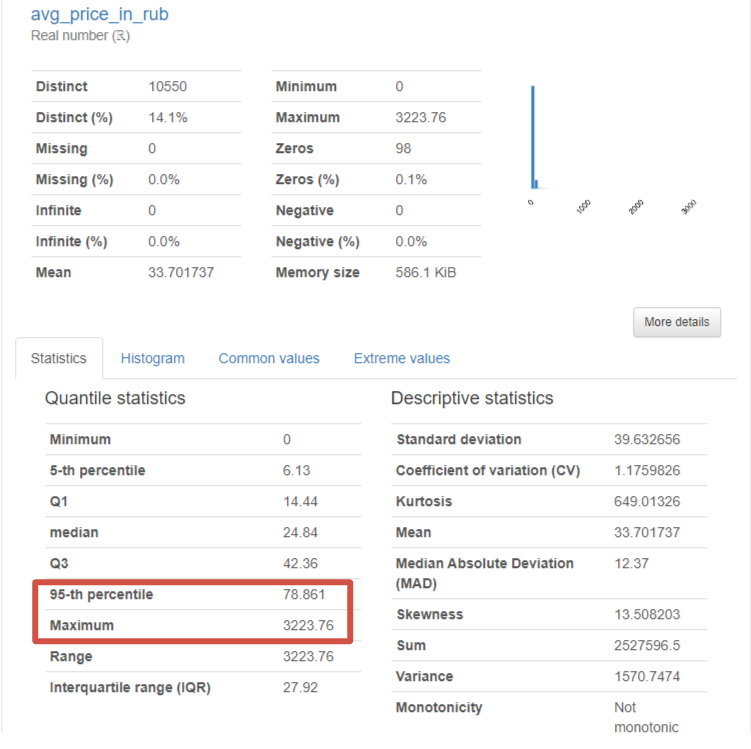

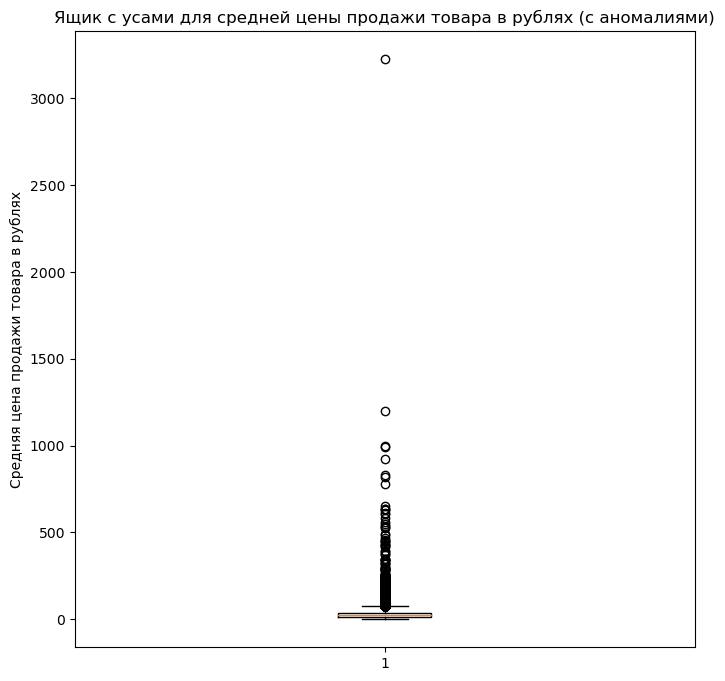

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(df_results.avg_price_in_rub)
ax.set_ylabel('Средняя цена продажи товара в рублях')
ax.set_title('Ящик с усами для средней цены продажи товара в рублях (с аномалиями)')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [22]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    
    return boundaries

In [23]:
boundaries = calculate_outliers(df_results.avg_price_in_rub)
boundaries

(-22.874999999999993, 74.76499999999999)

In [24]:
# найдем строки с выбросами в средней цене
is_outlier = (df_results.avg_price_in_rub < boundaries[0]) | (df_results.avg_price_in_rub > boundaries[1]) 
print(is_outlier.sum(),'выбросов')

2163 выбросов


In [25]:
df_results.loc[is_outlier].sort_values('avg_price_in_rub', ascending= False).head(60)

,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand
16902,76,d45763d0-c329-459b-abf8-8ea32ea19b55,ЛАПША БИГ-БОН 75 Г,Продукты на основе теста,2,6,3223.76,19342.56,2019,1,21,БИГ БОН
33422,63,52673392-4515-4363-a4d9-ed6352600b01,"ЛАПША ""БИГ БОН"" 95 ГР КУРИЦА+ПРЯНЫЙ СОУС СТАКАН 1/24 КОР",Продукты на основе теста,3,10,1197.08,11970.80,2019,2,9,БИГ БОН
41864,71,c0f15d54-cb6e-459c-8118-243cdd0a9421,ЛАПША ДОШИРАК КУРИЦА 90Г 1*24 (КОР) УП,Продукты на основе теста,2,2,995.38,1990.76,2019,2,19,ДОШИРАК
18027,71,671460f5-8ef5-46bb-a490-55005201d3f1,"ЛАПША 75Г 1*48 КУРИЦА + СОУС""САЛЬСА"" БИГБОН",Продукты на основе теста,1,13,992.86,12907.18,2019,1,22,БИГ БОН
41984,64,59b2e74a-5cf3-4fda-aea8-ee5d418cc6e8,"[БЕЗОП] ЛАПША В СТАКАНЕ ""РРОЛЛТОН"" 65 ГР МЯСО. УПАК",Продукты на основе теста,7,9,920.65,8285.85,2019,2,19,РОЛЛТОН
42124,64,b3e9c9f3-c225-4e01-a40e-83b8c6f75aa9,ЛАПША ДОШИРАК ГОВЯДИНА 90Г 1*24 (КОР) УП,Продукты на основе теста,10,10,833.32,8333.20,2019,2,20,ДОШИРАК
35881,69,660127c5-1315-4067-9887-8d8561c5ea57,ЛАПША БИГ-БОН МАКС 95 Г ПАКЕТ,Продукты на основе теста,2,8,819.11,6552.88,2019,2,12,БИГ БОН
40018,66,ad02b4bf-b9c5-457d-8e45-5042f6699401,"ЛАПША 75Г 1*48 ГОВЯДИНА + СОУС""ГУЛЯШ"" БИГБОН",Продукты на основе теста,5,10,781.57,7815.70,2019,2,17,БИГ БОН
62662,61,3cd4cf14-0f58-4972-a47e-94a181466598,"ЛАПША ""РРОЛЛТОН"" В ГОВЯДИНА (104) 1\42*60ГР. (КОР. (1 КОР.))",Продукты на основе теста,3,4,650.70,2602.80,2019,3,16,РОЛЛТОН
52392,63,8f1adfc8-47fc-4bb0-b82d-4c4318e2f27c,"ЛАПША ЯИЧНАЯ ""EGG NOODLES"" SEN SOY ПРЕМИУМ 4,5КГ/УП КИТАЙ ШТ",Паста,3,3,636.87,1910.61,2019,3,4,SEN SOY


В выбросы попали данные по лапше **длительного приготовления**, производимой брендами из нашего списка (УТОЧНИТЬ, НУЖНО ЛИ ВКЛЮЧАТЬ В ОТЧЕТ!!!)
Пока предположим, что нет, в таком случае удаляем строки, содержащие в item_name информацию о весе от 300 г (300, 350, 400)


In [26]:
index_del = df_results[(df_results.item_name.str.find('300') 
                        + df_results.item_name.str.find('400') 
                        + df_results.item_name.str.find('450')>= 0)].index
print('Количество строк весом от 300Г:', len(index_del))
df_results.drop(index_del, inplace=True)

Количество строк весом от 300Г: 1899


In [27]:
df_results[is_outlier].sort_values('avg_price_in_rub', ascending = False).head(60)

C:\Users\Виктория\AppData\Local\Temp\ipykernel_11984\2867513734.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_results[is_outlier].sort_values('avg_price_in_rub', ascending = False).head(60)


,region_code,seller_id,item_name,category,cheques_cnt,quantity,avg_price_in_rub,sum_in_rub,r_year,r_month,r_day,brand
16902,76,d45763d0-c329-459b-abf8-8ea32ea19b55,ЛАПША БИГ-БОН 75 Г,Продукты на основе теста,2,6,3223.76,19342.56,2019,1,21,БИГ БОН
33422,63,52673392-4515-4363-a4d9-ed6352600b01,"ЛАПША ""БИГ БОН"" 95 ГР КУРИЦА+ПРЯНЫЙ СОУС СТАКАН 1/24 КОР",Продукты на основе теста,3,10,1197.08,11970.80,2019,2,9,БИГ БОН
41864,71,c0f15d54-cb6e-459c-8118-243cdd0a9421,ЛАПША ДОШИРАК КУРИЦА 90Г 1*24 (КОР) УП,Продукты на основе теста,2,2,995.38,1990.76,2019,2,19,ДОШИРАК
18027,71,671460f5-8ef5-46bb-a490-55005201d3f1,"ЛАПША 75Г 1*48 КУРИЦА + СОУС""САЛЬСА"" БИГБОН",Продукты на основе теста,1,13,992.86,12907.18,2019,1,22,БИГ БОН
41984,64,59b2e74a-5cf3-4fda-aea8-ee5d418cc6e8,"[БЕЗОП] ЛАПША В СТАКАНЕ ""РРОЛЛТОН"" 65 ГР МЯСО. УПАК",Продукты на основе теста,7,9,920.65,8285.85,2019,2,19,РОЛЛТОН
42124,64,b3e9c9f3-c225-4e01-a40e-83b8c6f75aa9,ЛАПША ДОШИРАК ГОВЯДИНА 90Г 1*24 (КОР) УП,Продукты на основе теста,10,10,833.32,8333.20,2019,2,20,ДОШИРАК
35881,69,660127c5-1315-4067-9887-8d8561c5ea57,ЛАПША БИГ-БОН МАКС 95 Г ПАКЕТ,Продукты на основе теста,2,8,819.11,6552.88,2019,2,12,БИГ БОН
40018,66,ad02b4bf-b9c5-457d-8e45-5042f6699401,"ЛАПША 75Г 1*48 ГОВЯДИНА + СОУС""ГУЛЯШ"" БИГБОН",Продукты на основе теста,5,10,781.57,7815.70,2019,2,17,БИГ БОН
62662,61,3cd4cf14-0f58-4972-a47e-94a181466598,"ЛАПША ""РРОЛЛТОН"" В ГОВЯДИНА (104) 1\42*60ГР. (КОР. (1 КОР.))",Продукты на основе теста,3,4,650.70,2602.80,2019,3,16,РОЛЛТОН
52392,63,8f1adfc8-47fc-4bb0-b82d-4c4318e2f27c,"ЛАПША ЯИЧНАЯ ""EGG NOODLES"" SEN SOY ПРЕМИУМ 4,5КГ/УП КИТАЙ ШТ",Паста,3,3,636.87,1910.61,2019,3,4,SEN SOY


Оставшиеся выбросы  в основном обусловлены покупкой товара в оптовой упаковке (24 или 48 штук в коробке), что следует из наименования.

Однако самый большой выброс средней стоимости (3223.76 руб) может быть следствием ошибки ввода данных, так как в наименовании товара нет информации о большом количестве упаковок. Заменим его средним значением стоимости товара у данного производителя и пересчитаем сумму продажи.

In [28]:
df_results.loc[16902,'avg_price_in_rub'] = df_results[df_results.brand == 'БИГ БОН'].avg_price_in_rub.mean()
df_results.loc[16902,'sum_in_rub'] = df_results.loc[16902,'quantity'] * df_results.loc[16902,'avg_price_in_rub']
df_results.loc[16902, : ]

region_code                                           76
seller_id           d45763d0-c329-459b-abf8-8ea32ea19b55
item_name                            ЛАПША БИГ-БОН  75 Г
category                        Продукты на основе теста
cheques_cnt                                            2
quantity                                               6
avg_price_in_rub                               31.716289
sum_in_rub                                    190.297736
r_year                                              2019
r_month                                                1
r_day                                                 21
brand                                            БИГ БОН
Name: 16902, dtype: object

# Формирование отчета

Агрегируем данные по году, месяцу и производителю.
После агрегации проранжируем по количеству вхождений бренда и возмем ТОП-3

In [29]:
pd.options.display.float_format = '{:20.2f}'.format

In [30]:
# агрегация

agg_functions = { 
    'r_day': ['count'],
    'seller_id': ['nunique'],
    'cheques_cnt': ['sum'], 
    'quantity': ['sum'], 
    'sum_in_rub': ['sum']} 

df_report = df_results.groupby(['r_year', 'r_month', 'brand'], as_index=False).agg(agg_functions)
df_report.columns = ['r_year','r_month', 'brand', 'brand_count', 'seller_count', 'cheques_cnt','quantity','sum_in_rub']
df_report

,r_year,r_month,brand,brand_count,seller_count,cheques_cnt,quantity,sum_in_rub
0,2019,1,MIVIMEX,7,7,28,62,702.36
1,2019,1,SEN SOY,14,14,72,109,10388.55
2,2019,1,АНАКОМ,82,82,322,567,9216.42
3,2019,1,БИГ БОН,3384,2870,13934,24144,759106.88
4,2019,1,БИГ ЛАНЧ,256,253,1081,1851,71799.25
5,2019,1,БИЗНЕС ЛАНЧ,52,52,170,339,9950.13
6,2019,1,БИЗНЕС МЕНЮ,32,32,139,216,12003.66
7,2019,1,ДОШИРАК,8063,5551,33116,57635,1854265.13
8,2019,1,ЛАПШЫН,2061,1854,8223,14666,271757.15
9,2019,1,РОЛЛТОН,7833,5404,32148,56196,1382938.47


In [36]:
# ранжирование и подсчет средней цены продаж

df_report['brand_rank'] = df_report.groupby(['r_year', 'r_month'])['brand_count'].rank(ascending=False)
df_report['avg_price_in_rub'] = df_report['sum_in_rub'] / df_report['quantity'] 
df_report

,r_year,r_month,brand,brand_count,seller_count,cheques_cnt,quantity,sum_in_rub,brand_rank,avg_price_in_rub
0,2019,1,MIVIMEX,7,7,28,62,702.36,10.00,11.33
1,2019,1,SEN SOY,14,14,72,109,10388.55,9.00,95.31
2,2019,1,АНАКОМ,82,82,322,567,9216.42,6.00,16.25
3,2019,1,БИГ БОН,3384,2870,13934,24144,759106.88,3.00,31.44
4,2019,1,БИГ ЛАНЧ,256,253,1081,1851,71799.25,5.00,38.79
5,2019,1,БИЗНЕС ЛАНЧ,52,52,170,339,9950.13,7.00,29.35
6,2019,1,БИЗНЕС МЕНЮ,32,32,139,216,12003.66,8.00,55.57
7,2019,1,ДОШИРАК,8063,5551,33116,57635,1854265.13,1.00,32.17
8,2019,1,ЛАПШЫН,2061,1854,8223,14666,271757.15,4.00,18.53
9,2019,1,РОЛЛТОН,7833,5404,32148,56196,1382938.47,2.00,24.61


In [45]:
# формирование датафрейма с отчетом
df_end = df_report[df_report.brand_rank < 4][['r_year', 'r_month', 'brand', 'seller_count',  'cheques_cnt','quantity','sum_in_rub', 'brand_rank']]\
.sort_values(by=['r_year', 'r_month', 'brand_rank'], ignore_index=True)

In [46]:
df_end.drop('brand_rank', axis= 1 , inplace= True )
df_end

,r_year,r_month,brand,seller_count,cheques_cnt,quantity,sum_in_rub
0,2019,1,ДОШИРАК,5551,33116,57635,1854265.13
1,2019,1,РОЛЛТОН,5404,32148,56196,1382938.47
2,2019,1,БИГ БОН,2870,13934,24144,759106.88
3,2019,2,ДОШИРАК,5254,31090,53730,1768481.62
4,2019,2,РОЛЛТОН,5024,28246,50522,1245776.53
5,2019,2,БИГ БОН,2713,12770,22788,725548.64
6,2019,3,ДОШИРАК,5419,32117,56367,1819486.81
7,2019,3,РОЛЛТОН,5389,31805,55711,1397487.93
8,2019,3,БИГ БОН,2834,13399,23609,739582.28


# Сохранение данных в файл csv

In [47]:
df_end.to_csv ('Noodles_report.csv', index= False )